# **Trabalho 2**
## Grupo 22
Jo√£o Marques - a84684

Saimon Alves - a76575

In [2]:
import networkx as nx
import random 
import matplotlib.pyplot as plt
!pip install ortools
from ortools.linear_solver import pywraplp
import numpy

# Exerc√≠cio 1

1. Um sistema de tr√°fego  √© representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e  os arcos denotam vias de comunica√ß√£o s√≥ com um sentido . 
    >  O grafo tem de ser ligado o que significa que entre cada par de nodos $\langle n_1,n_2 \rangle$ tem de existir um caminho $n_1 \leadsto n_2$ e um caminho $n_2\leadsto n_1$.
    1. Gerar aleatoriamente um tal grafo com  $N=32$ nodos.  Cada nodo tem um n√∫mero aleat√≥rio de descendentes no intervalo $\,1..3\,$ cujos destinos s√£o distintos entre si do nodo origem. 
    2. Pretende-se fazer  manuten√ß√£o interrompendo  determinadas vias. Determinar o maior n√∫mero de vias que √© poss√≠vel remover mantendo o grafo ligado.

* Criamos uma fun√ß√£o que aproveitando-se da fun√ß√£o <u>is_strongly_connected</u> da $NetworkX$ cria um grafo fortemente conexo aleat√≥rio, com N nodos, e em que cada nodo tem um n√∫mero aleat√≥rio de descendentes no intervalo de $[1,3]$

In [16]:
def gerar(N):
    g = nx.DiGraph()
    
    #gerar continuamente grafos at√© conseguirmos gerar um fortemente conexo
    while(nx.is_empty(g) or nx.is_strongly_connected(g) != True ):
        #Adicionar ao grafo N nodos
        for n in range(N):
            g.add_node(n)
    
        #A cada nodo adicionar adicionar 1 a 3 descendentes 
        for n in g.nodes():
            k1 = random.randint(1,3)
            for i in range(k1):
                k2 = random.randint(0,N-1)
                while g.has_edge(n,k2) or g.has_edge(k2,n) or n == k2:
                    k2 = random.randint(0,N-1)
                g.add_edge(n,k2)
            
    
    
    return g

In [22]:
G = gerar(11)

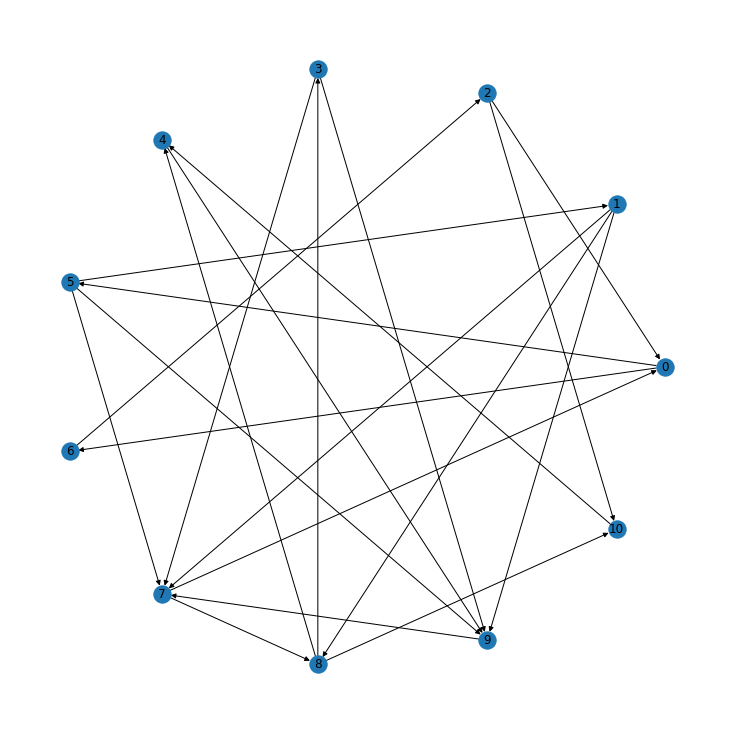

In [23]:
plt.figure(figsize=(10,10))
pos = nx.circular_layout(G)
nx.draw(G,pos,with_labels = True)


* Na fun√ß√£o $manutencao$, vamos reduzir ao m√°ximo o n√∫mero de arestas do grafo G, mantendo o grafo ligado, aproveitando-nos do solver $SCIP$. 
    * Come√ßamos por criar a vari√°vel $A_e$ em que se uma aresta e pertence ao grafo $G$ ent√£o $A_e = 1$
    * Depois criamos a vari√°vel $Caminhos_(o,d)c$, onde $c \in C$, que gra√ßas ao uso da <u>all_simple_paths</u> conter√° todos os caminhos $c$ entre os vertices $(n1,n2)$
* <u>Restri√ß√µes</u>:
    1. $ \forall {(o,d) \in G}, \forall {c \in C} , \forall {e \in c} , A_e \ge Caminhos_(o,d)c$
    2. $\forall{(o,d)\in G},\sum_{\forall{c \in C}} Caminhos(o,d)c \ge 1$

    

In [24]:
#Determinar o conjunto de arestas de um determinado caminho
def conj(c):
    return [(c[i],c[i+1]) for i in range(len(c)-1)]

In [25]:
def manutencao(g):
    manu = pywraplp.Solver_CreateSolver('SCIP')
    A = {}

    #criar vari√°veis para todas as arestas
    for e in g.edges():
        A[e]=manu.BoolVar(str(e))
    
    #garantir que existe um caminho entre cada par de v√©rtices
    for n1 in g.nodes():
        for n2 in g.nodes():
            if (n1!=n2):
                caminhos = {}
                counter = 0
                for c in nx.all_simple_paths(g,n1,n2):
                    #adicionar vari√°veis para as arestas do caminho
                    caminhos[counter] = manu.BoolVar('(' + str(n1) + str(n2) + ") -" + str(counter))
                    for arestas in conj(c):
                        manu.Add(A[arestas]>=caminhos[counter])
                    manu.Add(sum(caminhos.values())>= 1)
                    counter+=1
    
    #minimizar o n√∫mero de arestas do grafo
    manu.Minimize(sum(A.values()))
    status = manu.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        rem = []
        for e in g.edges():
            if round(A[e].solution_value()) == 0:
                rem.append(e)
        glinha = g.copy()
        for n1,n2 in g.edges:
            if (n1,n2) in rem:
                glinha.remove_edge(n1,n2) 
        print("O n√∫mero de vias removidas que podem ser removidas: ", len(rem))
        return glinha

    else:
        print("Impossivel remover arestas mantendo o grafo ligado")
        return g

                
            

O n√∫mero de vias removidas que podem ser removidas:  5


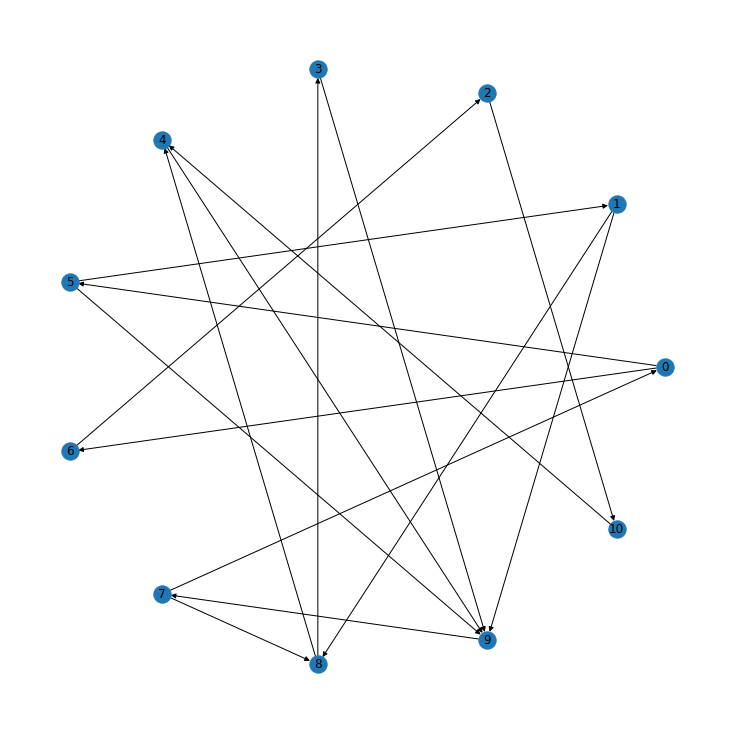

In [26]:
glinha = manutencao(G)
plt.figure(figsize=(10,10))
pos = nx.circular_layout(glinha)
nx.draw(glinha,pos, with_labels = True)

# Exerc√≠cio 2

 2. Considere-se um circuito booleano $\,\mathcal{C}\,$ com $\,n\,$ ‚Äúwires‚Äù de ‚Äúinput‚Äù e um √∫nico ‚Äúwire‚Äù de output.
    - O circuito √© descrito num bi-grafo com uma classe de nodos representando ‚Äúgates‚Äù e a segunda classe representando ‚Äúwires‚Äù . 
    - Cada nodo cont√©m um campo val cujo conte√∫do descreve a sem√¢ntica desse nodo; para os ‚Äúwires‚Äù o campo val  cont√©m uma vari√°vel SCIP; para as ‚Äúgates‚Äù o campo val  cont√©m uma marca bo conjunto and, or,  xor e not,   que indica o tipo de ‚Äúgate‚Äù. 
    - Com exce√ß√£o de not , que √© um operador un√°rio, todas as restantes ‚Äúgates‚Äù t√™m um n√∫mero arbitr√°rio de ‚Äúinputs‚Äù e um √∫nico ‚Äúoutput‚Äù.
    - No grafo os arcos com origem numa determinada ‚Äúgate‚Äù  t√™m destino nos ‚Äúwires‚Äù que s√£o ‚Äúinput‚Äù dessa ‚Äúgate‚Äù. Cada ‚Äúwire‚Äù que n√£o √© ‚Äúinput‚Äù √© origem de um √∫nico arco que tem como destino a ‚Äúgate‚Äù do qual esse ‚Äúwire‚Äù √© ‚Äúoutput‚Äù.
    - A sem√¢ntica das v√°rias ‚Äúgates‚Äù √© expressa em rela√ß√µes na Aritm√©tica Linear Inteira, tal como est√° descrita em +Cap√≠tulo 2: Programa√ß√£o com Restri√ß√µes (#LIA)
    
    a. Escreva um programa que, a partir do n√∫mero $\,n\,$ de ‚Äúinputs‚Äù  e de um par√¢metro positivo $\,\gamma\ll 1\,$ como argumentos,  gere aleatoriamente circuitos com ‚Äúgates‚Äù or, and e not  em que o n√∫mero de and's √©  $\,\gamma\ast\,$ (n√∫mero total de nodos).
    
    b. Escreva um programa Python que leia um circuito arbitr√°rio descrito pelo bi-grafo anterior e formule as restri√ß√µes (em Programa√ß√£o Inteira) que descrevem as v√°rias ‚Äúgates‚Äù do circuito.
    
    c. Usando os dois programas anteriores e o sistema SCIP: </p>
    - i. Escreva um programa que determine um vetor de ‚Äúinputs‚Äù   $\,x\in\{0,1\}^n\,$ aceite pelo circuito (i.e. o respetivo output √© $1$). </p>
    - ii. Determine o vetor $x'\neq x$ , tamb√©m aceite pelo circuito, que est√° mais pr√≥ximo de $x$.

# *Compreens√£o do Problema*

Para resolver o problema 2, queremos criar um circuito booleano que tenha um certo n√∫mero obrigat√≥rio de "gates" do tipo  ùëéùëõùëë  para depois o resolver. 
No circuito existem  ùëÅ  nodos, os quais t√™m um valor atribu√≠do, este valor pode ser:  ùëñùëõùëùùë¢ùë°  (para os n√≥s que v√£o ser o vetor de input no circuito),  ùëúùë¢ùë°ùëùùë¢ùë°  (nodos que saiem de um gate),  ùëéùëõùëë  (‚àß),  ùëúùëü  (‚à®),  ùëõùëúùë°  (¬¨) e  ùë•ùëúùëü  (‚äï). Os atributos  ùëñùëõùëùùë¢ùë°  e  ùëúùë¢ùë°ùëùùë¢ùë°  fazem parte da categoria  ùë§ùëñùëüùëí  e os restantes √† categoria  ùëîùëéùë°ùëí .


In [10]:
def random_circuit(inp,p):
    g = nx.DiGraph()
    gates = []
    wires = []
    nodos = 0
    n_or = random.randint(1,inp)
    n_not = random.randint(1,inp)
    n_and = int(p * (n_or+n_not))

    #adicionar inputs
    for i in range(inp):
        g.add_node(i, type ='INPUT')
        nodos += 1

    #adicionar gates
    for i in range(n_or):
        nodos+=1
        g.add_node(nodos, type = 'OR')
    for i in range(n_not):
        nodos+=1
        g.add_node(nodos, type='NOT')
    for i in range(n_and):
        nodos+=1
        g.add_node(nodos, type='AND')

    #adicionar wires
    for i in range(nodos-inp):
        g.add_node(nodos+i, type='WIRE')

    for n in g.nodes():
        if g.nodes[n]['type'] != 'INPUT' and g.nodes[n]['type'] != 'WIRE' :
            gates.append(n)
    for n in g.nodes():
        if g.nodes[n]['type'] == "WIRE":
            wires.append(n)

    #emparelhar cada gate com um wire aleat√≥rio
    for n in g.nodes():
        if g.nodes[n]['type'] != 'WIRE':
            node = random.choice(wires)
            g.add_edge(n,node)
            wires.remove(node)
    
    #escolher um dos gates emparelhados para servir como output final
    output = random.choice(gates)
  
